In [ ]:
import tarfile
import urllib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [ ]:
uci_tcga_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00401/"
archive_name = "TCGA-PANCAN-HiSeq-801x20531.tar.gz"

# Build the url
full_download_url = urllib.parse.urljoin(uci_tcga_url, archive_name)

# Download the file
r = urllib.request.urlretrieve (full_download_url, archive_name)

# Extract the data from the archive
tar = tarfile.open(archive_name, "r:gz")
tar.extractall()
tar.close()

In [ ]:
datafile = "TCGA-PANCAN-HiSeq-801x20531/data.csv"
labels_file = "TCGA-PANCAN-HiSeq-801x20531/labels.csv"

data = np.genfromtxt(
    datafile,
    delimiter=",",
    usecols=range(1, 20532),
    skip_header=1
)

true_label_names = np.genfromtxt(
    labels_file,
    delimiter=",",
    usecols=(1,),
    skip_header=1,
    dtype="str"
)

In [ ]:
data[5:,:5]

array([[0.        , 3.46785331, 3.58191761, 6.62024329, 9.70682924],
       [0.        , 1.22496637, 1.6911768 , 6.57200741, 9.64051067],
       [0.        , 2.85485343, 1.75047788, 7.22672045, 9.75869127],
       ...,
       [0.        , 3.24958187, 3.70749166, 8.18590123, 9.50408206],
       [0.        , 2.59033853, 2.78797567, 7.31862415, 9.98713608],
       [0.        , 2.32524248, 3.80593214, 6.53024557, 9.56036723]])

In [ ]:
data.shape

(801, 20531)

In [ ]:
true_label_names[:5]

array(['PRAD', 'LUAD', 'PRAD', 'PRAD', 'BRCA'], dtype='<U4')

In [ ]:
# label encode true label names
le=LabelEncoder()
true_labels=le.fit_transform(true_label_names)
print(true_labels[:5])
n_clusters=len(le.classes_)
n_clusters

[4 3 4 4 0]


5

## Dimension Reduction

In [ ]:
# Since its a high dimensional date set, applying PCA to reduce the dimension to 2
# Using pipelines to perfrom feature scaling and dimension reduction
preprocessor=Pipeline(
    [
     ("sc", MinMaxScaler()),
     ('pca', PCA(n_components=2, random_state=42)),
    ]
)

## Building cluster

In [ ]:
# Performing k Means
clustering= Pipeline(
    [
     ("kmeans", KMeans(n_clusters=n_clusters, init='k-means++', n_init=50,
                       max_iter=500, random_state=42))
    ]
)

In [ ]:
# chaining Pipelines
pipe = Pipeline(
    [
     ("preprocessor", preprocessor),
     ("clustering", clustering)
    ]
)

In [ ]:
# Calling fit method
pipe.fit(data)

Pipeline(memory=None,
         steps=[('preprocessor',
                 Pipeline(memory=None,
                          steps=[('sc',
                                  MinMaxScaler(copy=True,
                                               feature_range=(0, 1))),
                                 ('pca',
                                  PCA(copy=True, iterated_power='auto',
                                      n_components=2, random_state=42,
                                      svd_solver='auto', tol=0.0,
                                      whiten=False))],
                          verbose=False)),
                ('clustering',
                 Pipeline(memory=None,
                          steps=[('kmeans',
                                  KMeans(algorithm='auto', copy_x=True,
                                         init='k-means++', max_iter=500,
                                         n_clusters=5, n_init=50, n_jobs=None,
                                         precompute

## Model Evaluation

The scale for each of these clustering performance metrics ranges from -1 to 1. A silhouette coefficient of 0 indicates that clusters are significantly overlapping one another, and a silhouette coefficient of 1 indicates clusters are well-separated.

In [ ]:
# Using Silhouette Coefficient
preprocessed_data=pipe['preprocessor'].transform(data)
predicted_labels=pipe['clustering']['kmeans'].labels_
silhouette_score(preprocessed_data, predicted_labels)

0.5118775528450308

An ARI score of 0 indicates that cluster labels are randomly assigned, and an ARI score of 1 means that the true labels and predicted labels form identical clusters.

In [ ]:
# Using RAND since we have true labels
adjusted_rand_score(true_labels, predicted_labels)

0.722276752060253

## Visualizing Clusters

In [ ]:
# we need the 2 components of pca to visualize the points in 2D space
pcadf=pd.DataFrame(pipe['preprocessor'].transform(data),
                   columns=['comp_1','comp2']
)
pcadf.head()

,comp_1,comp2
0,-5.668141,-8.872139
1,-1.470204,10.280182
2,-10.845387,-1.345352
3,-9.167961,-8.670123
4,-6.271848,-3.101208


In [ ]:
pcadf["predicted_cluster"]=pipe['clustering']['kmeans'].labels_

In [ ]:
pcadf['true_labels']=le.inverse_transform(true_labels)

In [ ]:
pcadf.head()

,comp_1,comp2,predicted_cluster,true_labels
0,-5.668141,-8.872139,2,PRAD
1,-1.470204,10.280182,3,LUAD
2,-10.845387,-1.345352,0,PRAD
3,-9.167961,-8.670123,2,PRAD
4,-6.271848,-3.101208,0,BRCA


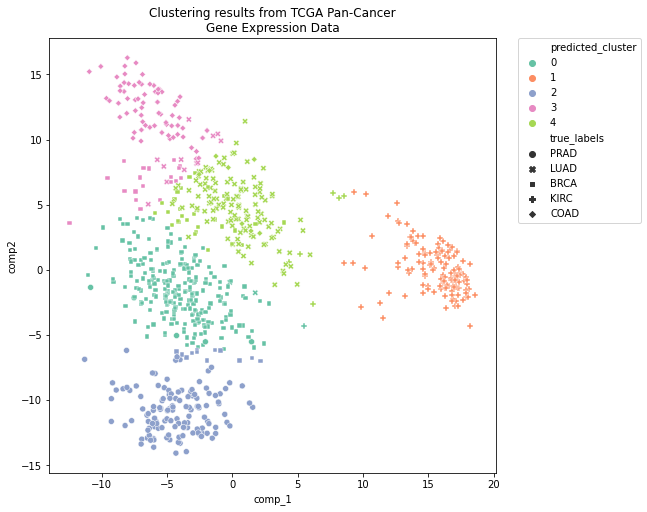

In [ ]:
plt.figure(figsize=(8,8))
scat=sns.scatterplot(
    x='comp_1', y='comp2', data=pcadf, 
    hue='predicted_cluster', style='true_labels', palette="Set2"
)
scat.set_title(
    "Clustering results from TCGA Pan-Cancer\nGene Expression Data"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.show()

The clusters only slightly overlapped

## Parameter Tuning
The overlap was caused because of squishing multiple components to 2. The explained variance went down. Hence we could look for a good number to fix the number of components in PCA

In [ ]:
silhouette_scores=[]
ari_scores=[]
for n in range(2,11):
  pipe['preprocessor']['pca'].n_components=n
  pipe.fit(data)

  silhouette_coef=silhouette_score(
      pipe['preprocessor'].transform(data),
      pipe['clustering']['kmeans'].labels_,
      )
  ari=adjusted_rand_score(true_labels,pipe['clustering']['kmeans'].labels_)
  silhouette_scores.append(silhouette_coef)
  ari_scores.append(ari)

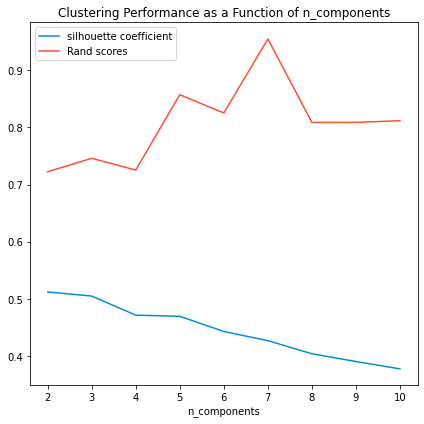

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(
    range(2,11),
    silhouette_scores,
    c="#008fd5",
    label='silhouette coefficient',
)
plt.plot(
    range(2,11),
    ari_scores,
    c="#fc4f30",
    label='Rand scores',
)
plt.xlabel("n_components")
plt.legend()
plt.title("Clustering Performance as a Function of n_components")
plt.tight_layout()
plt.show()

The ARI improves significantly as you add components. It appears to start tapering off after n_components=7, so that would be the value to use for presenting the best clustering results from this pipeline.